<a href="https://colab.research.google.com/github/jongkwangyun/quant/blob/main/%EB%B9%84%ED%8A%B8%EC%BD%94%EC%9D%B8_5_20_60_120_200%EC%9D%BC_%EC%9D%B4%ED%8F%89%EC%84%A0_%EB%B9%84%EC%9C%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests
print()
!pip install pandas
print()
!pip install matplotlib

현재가가 이동평균선보다 위: 5, 20, 60, 120, 200
비트코인 투자비율: 100%
현재가가 120일 이동평균선 위인지: True

가격 순서 (가장 높은 가격부터):
now: 98,489
ma5: 97,162
ma20: 96,816
ma60: 94,990
ma120: 79,716
ma200: 72,231


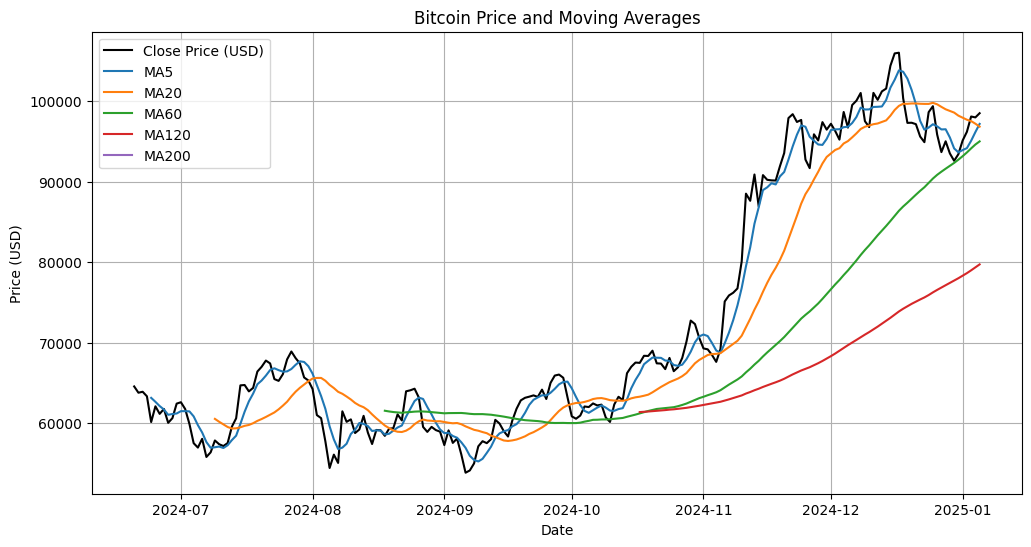

In [12]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# 1. Upbit에서 비트코인 데이터 가져오기 (USD 표시)
def fetch_upbit_ohlcv_usdt(market="USDT-BTC", count=200):
    """Upbit에서 지정한 마켓의 OHLCV 데이터를 가져옵니다 (USD 기반)."""
    url = "https://api.upbit.com/v1/candles/days"
    params = {"market": market, "count": count}
    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code}")
    data = response.json()

    # DataFrame으로 변환
    df = pd.DataFrame(data)
    df["timestamp"] = pd.to_datetime(df["candle_date_time_utc"])
    df = df[["timestamp", "trade_price"]]
    df.columns = ["timestamp", "close"]
    df = df[::-1].reset_index(drop=True)  # 최신 날짜를 맨 뒤로 정렬
    return df

# 2. 이동평균선 계산
def calculate_moving_averages(df, windows=[5, 20, 60, 120, 200]):
    """이동평균선을 계산하고 DataFrame에 추가합니다."""
    for window in windows:
        df[f"ma{window}"] = df["close"].rolling(window=window).mean()
    return df

# 3. 현재 가격과 이동평균선 비교
def compare_with_moving_averages(df, windows=[5, 20, 60, 120, 200]):
    """현재 가격이 각 이동평균선 위에 있는지 비교합니다."""
    latest_close = df["close"].iloc[-1]
    comparisons = {f"ma{window}": latest_close > df[f"ma{window}"].iloc[-1] for window in windows}
    count_above = sum(comparisons.values())
    percentage_above = count_above / len(windows) * 100
    is_above_120 = comparisons["ma120"]

    # 각 이동평균선과 현재 가격 출력
    ma_prices = {f"ma{window}": df[f"ma{window}"].iloc[-1] for window in windows}
    ma_prices["now"] = latest_close

    # 가격이 높은 순서대로 정렬
    sorted_ma_prices = sorted(ma_prices.items(), key=lambda x: x[1], reverse=True)

    return comparisons, count_above, percentage_above, is_above_120, sorted_ma_prices

# 4. 시각화
def plot_moving_averages(df, windows=[5, 20, 60, 120, 200]):
    """비트코인 가격과 이동평균선을 시각화합니다."""
    plt.figure(figsize=(12, 6))
    plt.plot(df["timestamp"], df["close"], label="Close Price (USD)", color="black")
    for window in windows:
        plt.plot(df["timestamp"], df[f"ma{window}"], label=f"MA{window}")
    plt.title("Bitcoin Price and Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

# 5. 실행
try:
    # 데이터 가져오기
    df = fetch_upbit_ohlcv_usdt()
    # 이동평균선 계산
    df = calculate_moving_averages(df)
    # 이동평균선과 비교
    comparisons, count_above, percentage_above, is_above_120, sorted_ma_prices = compare_with_moving_averages(df)

    # 출력 형식에 맞게 결과 표시
    print("현재가가 이동평균선보다 위:", ", ".join([str(window).replace('ma', '') for window, is_above in comparisons.items() if is_above]))
    print(f"비트코인 투자비율: {percentage_above:.0f}%")
    print(f"현재가가 120일 이동평균선 위인지: {is_above_120}")

    # 가격 순서대로 출력
    print("\n가격 순서 (가장 높은 가격부터):")
    for ma, price in sorted_ma_prices:
        print(f"{ma}: {price:,.0f}")

    # 시각화
    plot_moving_averages(df)
except Exception as e:
    print("Error:", e)